In [1]:
%load_ext autoreload
%autoreload 2

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import itertools
import time
from IPython.display import clear_output

from sklearn.decomposition import PCA
import scipy

import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.distributions as TD
from torchvision.utils import make_grid
from torchvision import transforms

import pickle
import os
import sys
from tqdm.notebook import tqdm
from scipy.stats import multivariate_normal


# for IWAE
from scipy.stats import multivariate_normal
from matplotlib import ticker, cm
from matplotlib import gridspec
from scipy.special import logsumexp
# end for IWAE

if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 2
    torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'
# DEVICE='cpu'

import warnings
warnings.filterwarnings('ignore')

# <span style="color:red"> No! </span>

# dgm_utils
from dgm_utils import train_model, plot_training_curves, show_samples
from dgm_utils import visualize_2d_samples, visualize_2d_densities, visualize_2d_data

# <center>Deep Generative Models</center>
## <center>Seminar 4</center>

<center>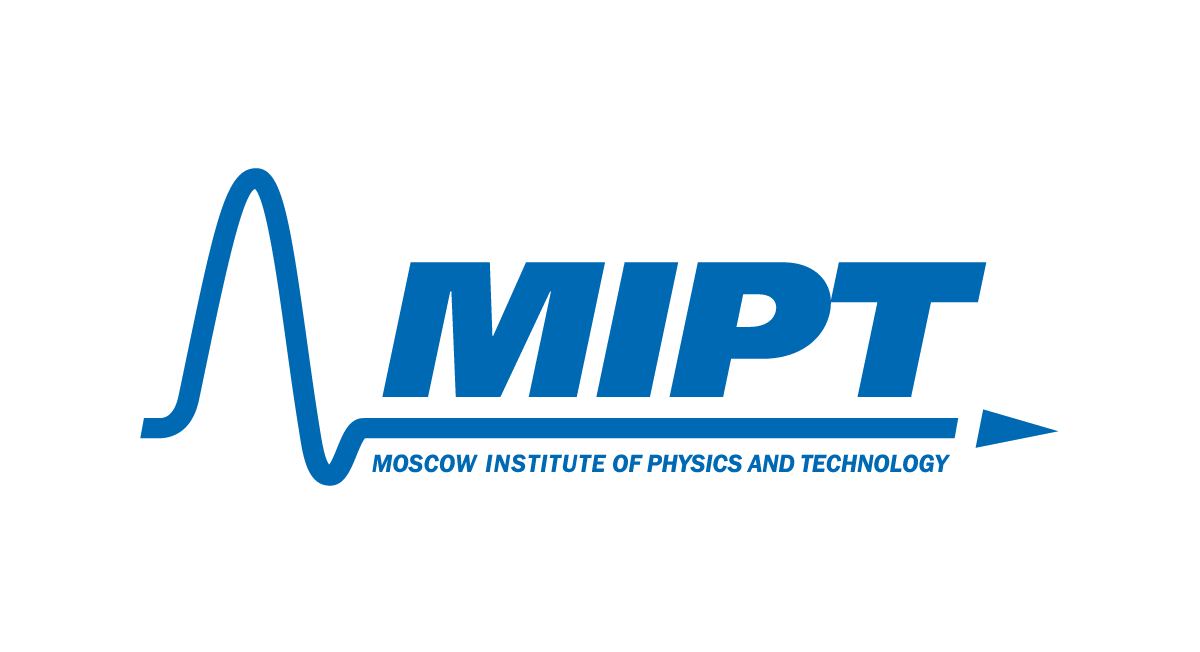</center>
<center>26.09.2022</center>


## Plan

0. Variational EM algorithm for GMM (from previous seminar)

1. VAE 
    
    - VAE implementation hints
    
    - VAE on 2D data coding

2. Posterior collapse and decoder weakening
    

## VAE

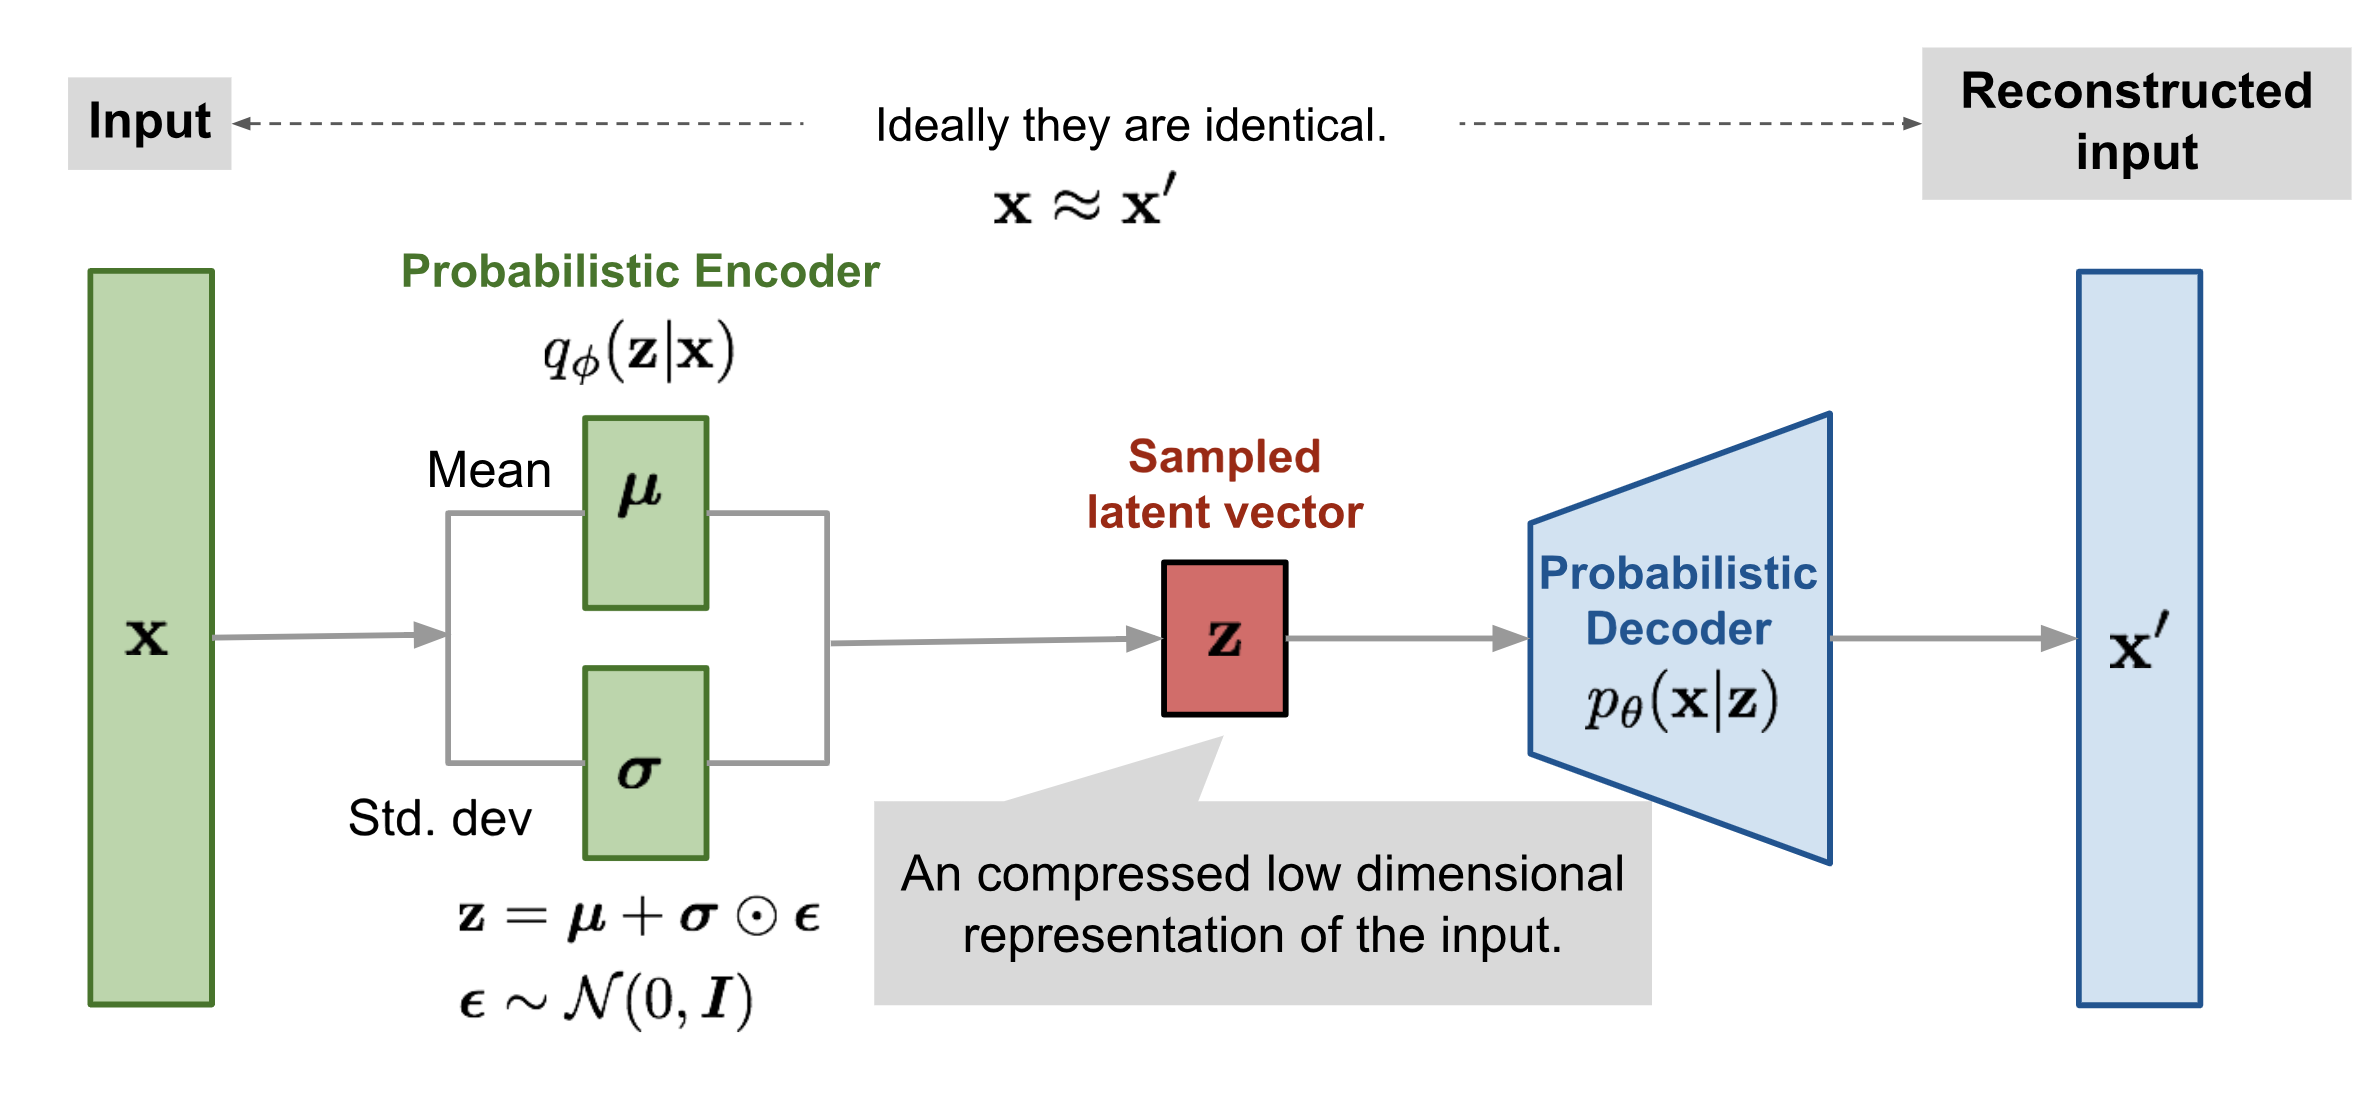

$x_1, \dots x_n$ is samples from unknown distribution $p(x)$

$$L(q, \theta) = \mathbb{E}_{z_1, \dots z_N \sim q(\boldsymbol{z}| \boldsymbol{x}, \phi)} \ln p(x_1, \dots x_N|\boldsymbol{z}, \theta) - KL(q(z_1, \dots, z_N| \boldsymbol{x}, \phi)||p(z_1, \dots , z_N))$$

In the questions below consider 2 cases:

* $2D$ data
* Images data

**Question 1.** How to model VAE encoder $q(\boldsymbol{z} | \boldsymbol{x}, \phi)$? What does the encoder take as **input**? What is the **output** of the encoder?

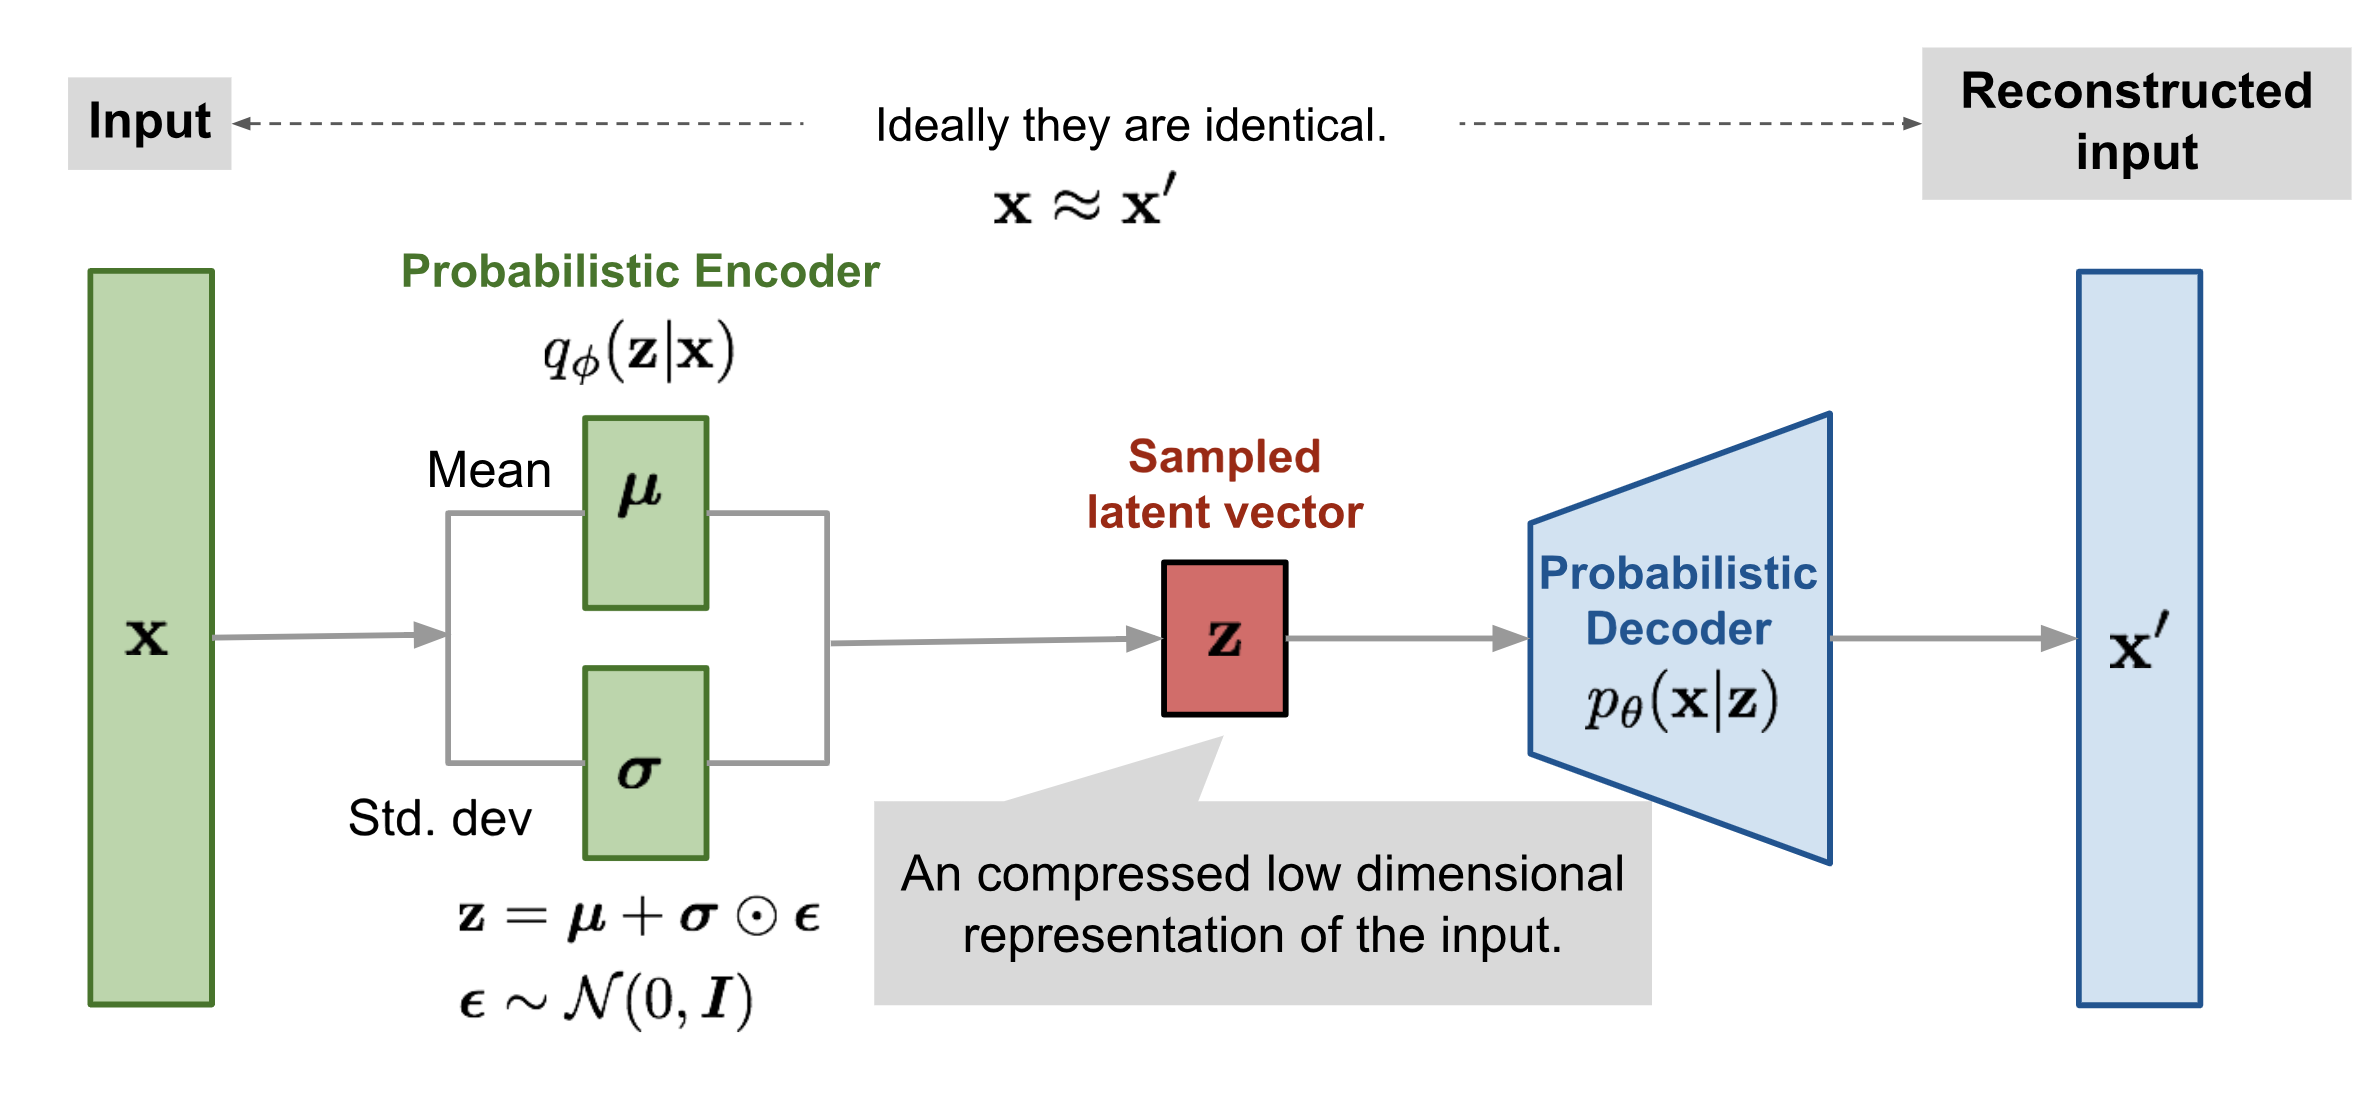

```python
# x : tensor (bs, 2) - first case
#   : tensor (bs, 3, w, h) - second case

z_stats = VAEEncoder(x) # (bs, 2*z_dim)

mu_z = z_stats[:, :z_dim] #(bs, z_dim)
log_sigma_z = z_stats[:, z_dim:] # (bs, z_dim)
```

**Question 2.** How to model VAE decoder $p(\boldsymbol{x} | \boldsymbol{z}, \theta)$? What does the decoder take as **input**? What is the **output** of the decoder?

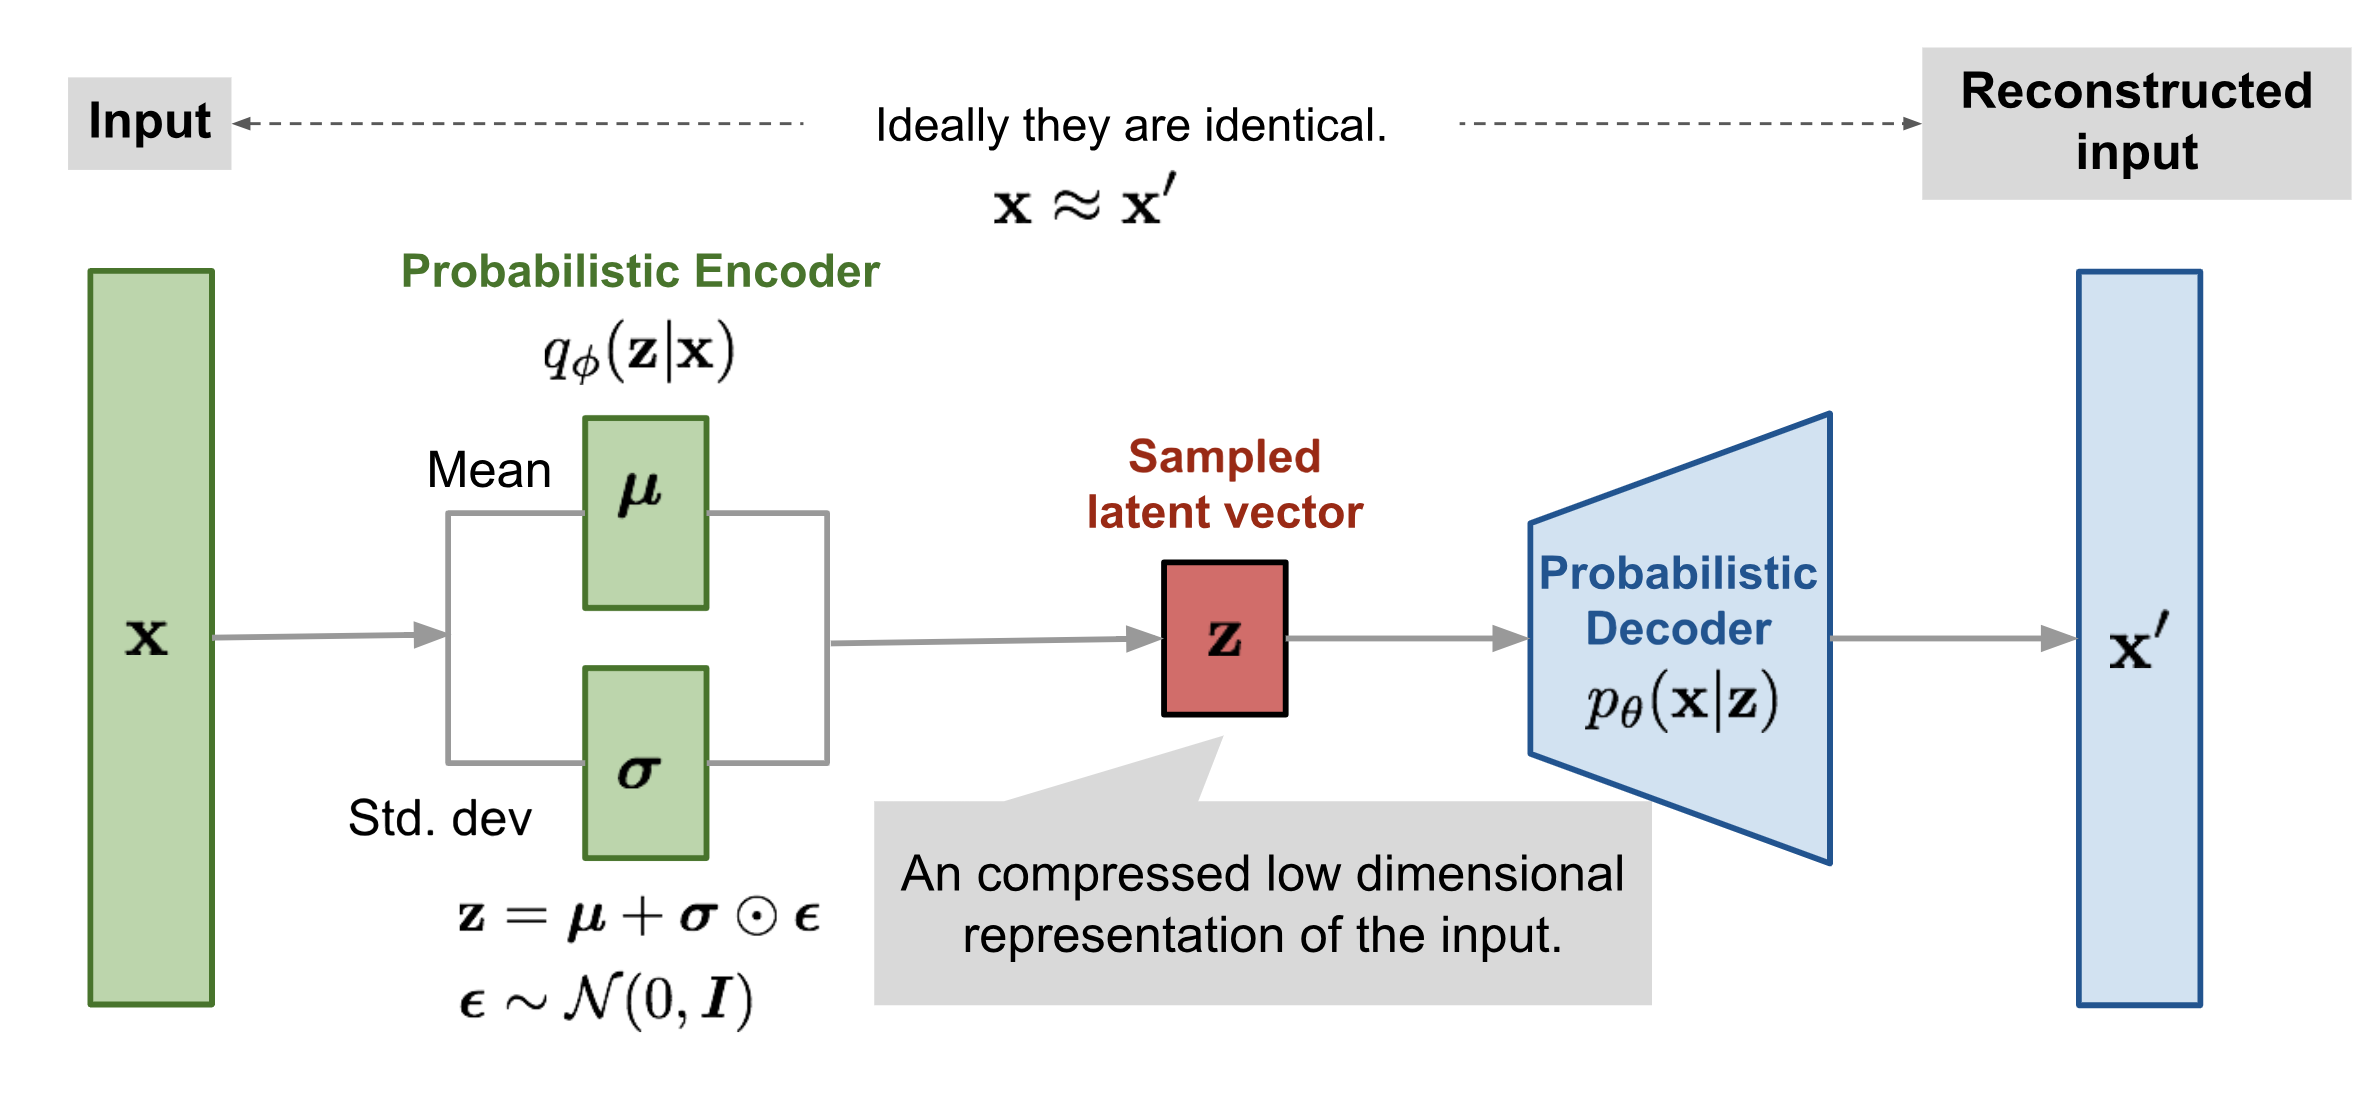

```python
# z : tensor (bs, z_dim)

X_stats = VAEDecoder(z) # X : tensor (bs, 2 * 2) - first case
                        #   : tensor (bs, 3, w, h ) - second case (predict only mu's!)
...

if not sample_from_decoder:
    return \mu_X
else:
    return sample N(\mu_X, \sigma_X)
```

**Question 3.** How to model $p(z)$?

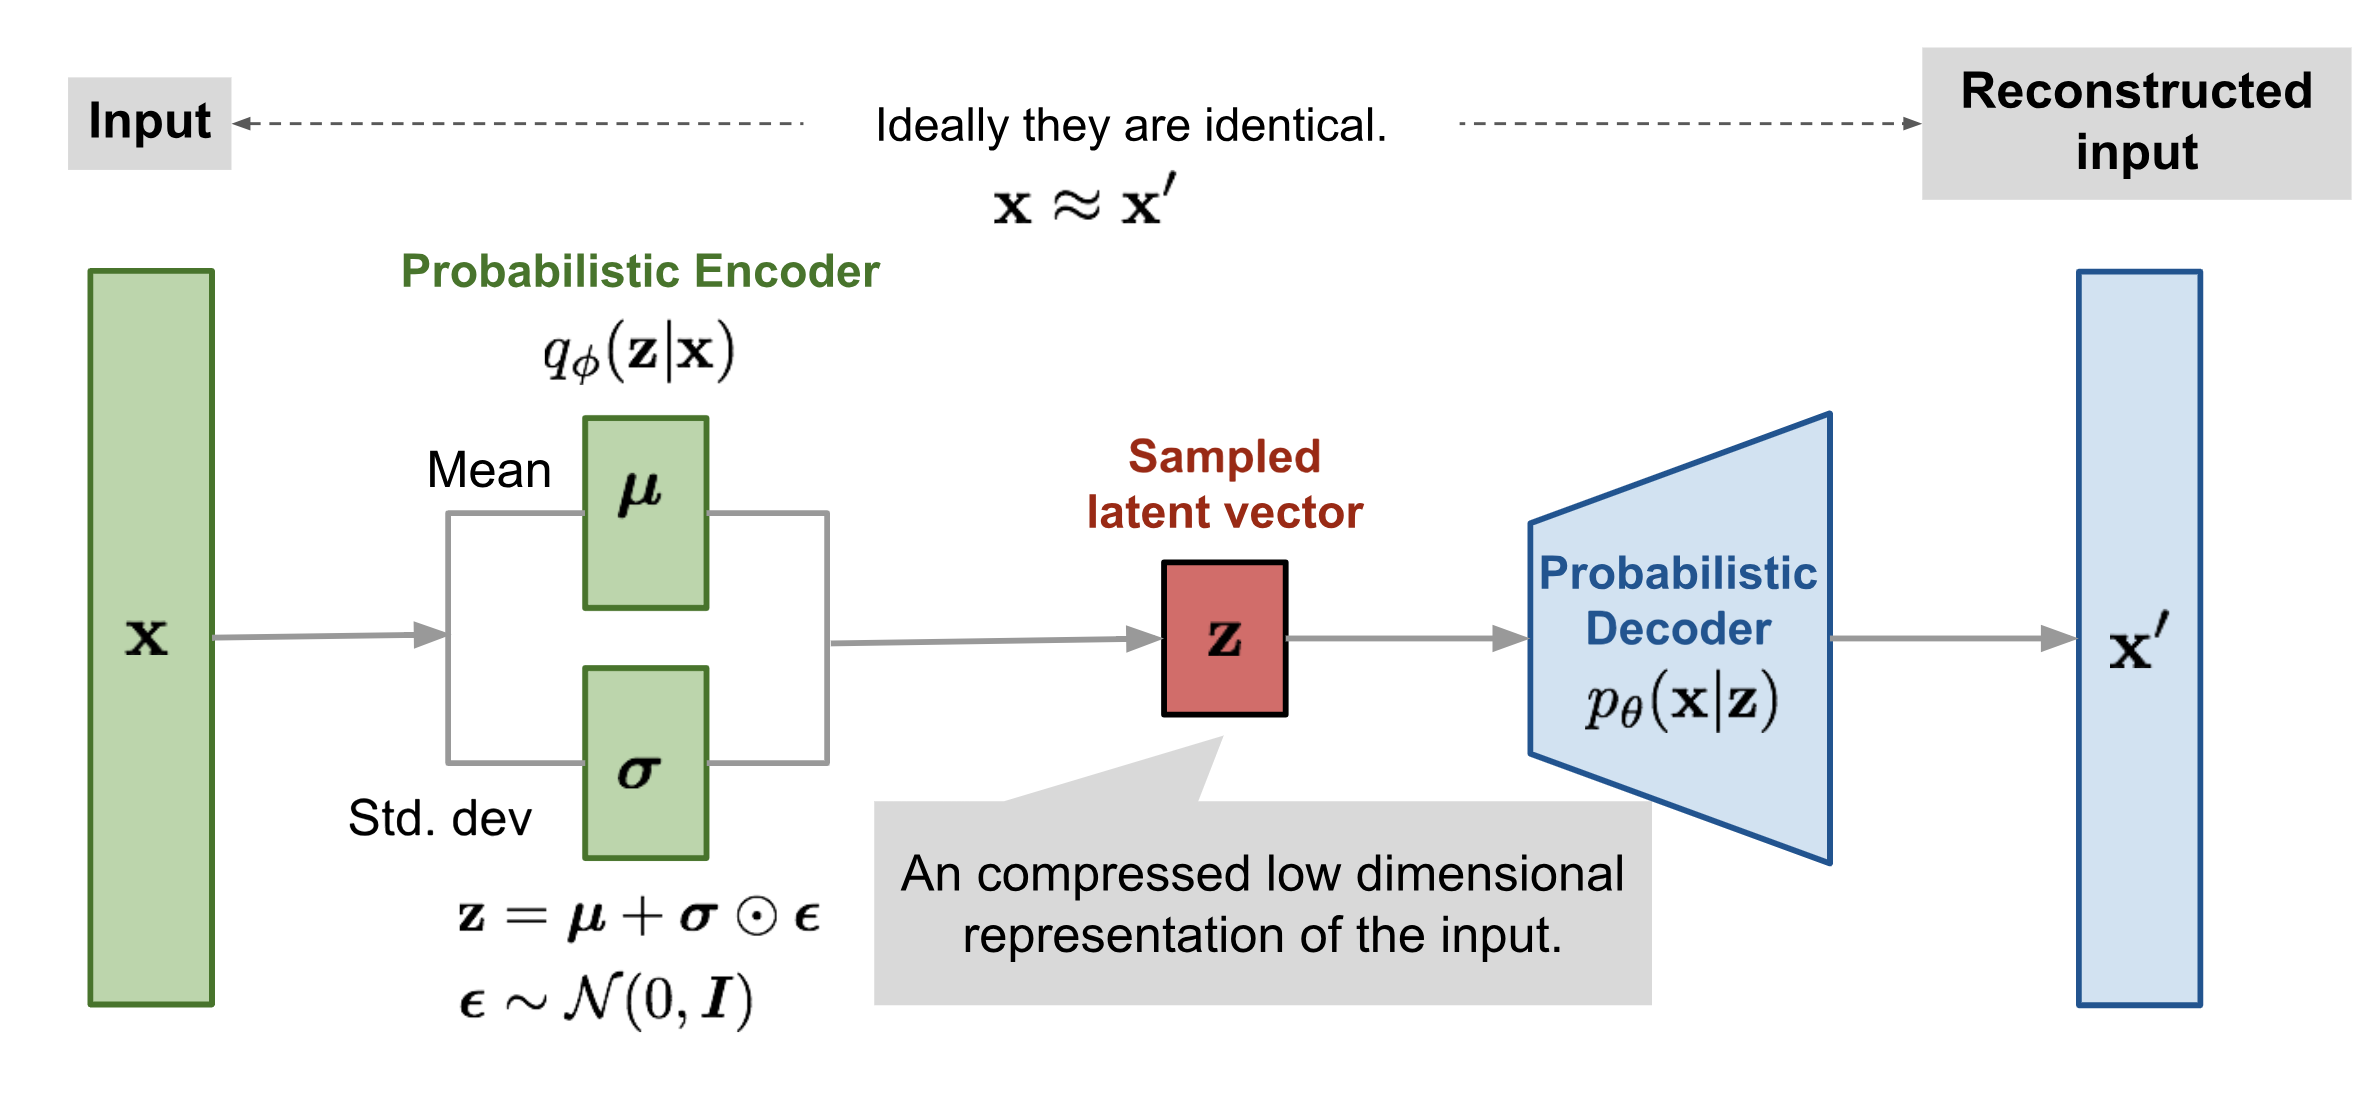

$\mathcal{N}(0, I_{\text{z_dim}})$

**Question 4.** How to sample from VAE?

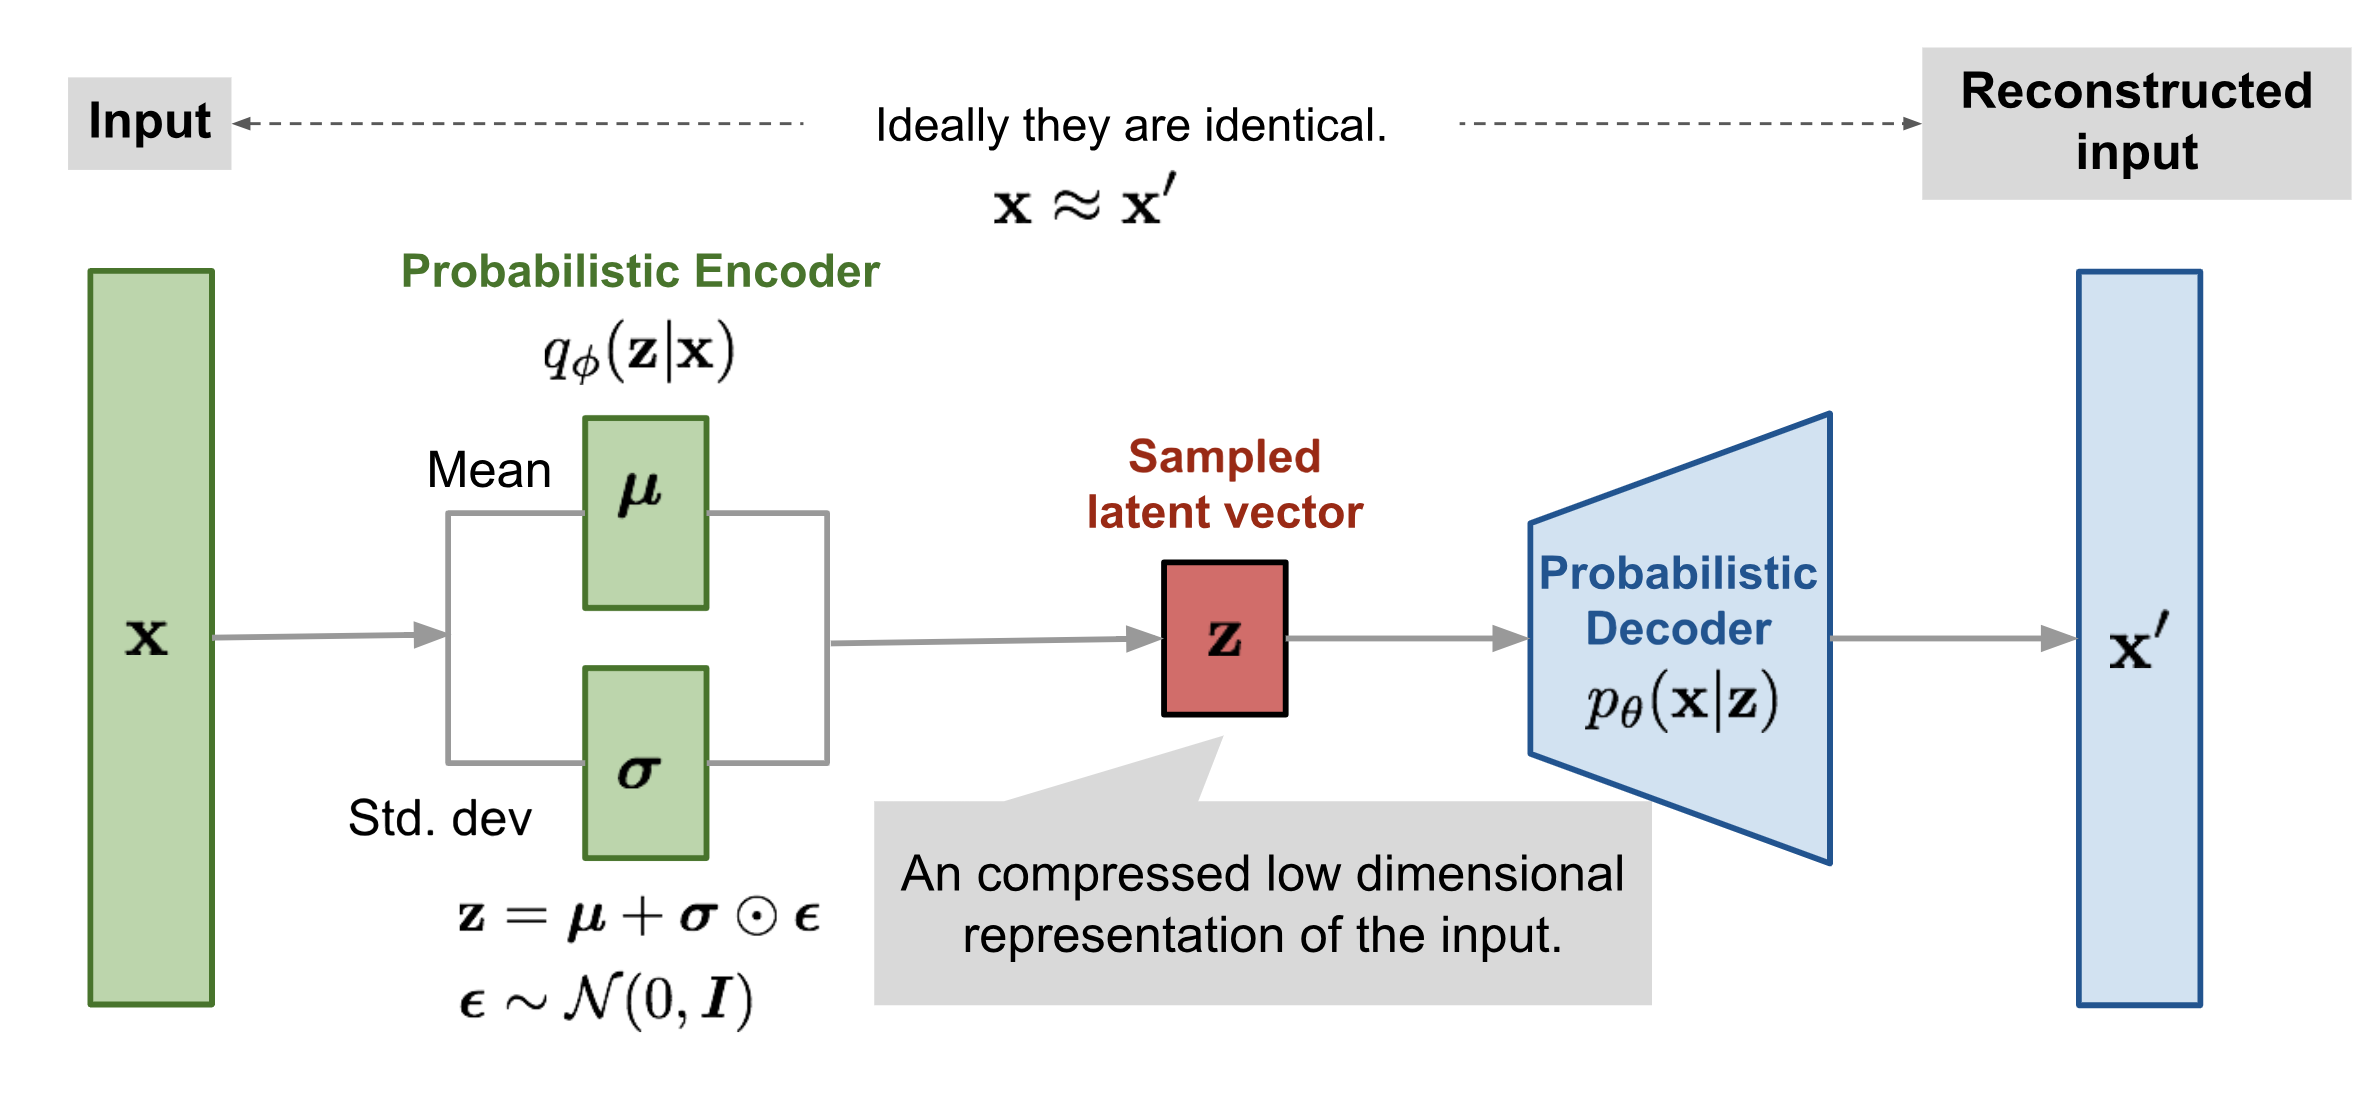

```python
1. z_sample = samples N(0, I_{z_dim}) of shape (bs,) # tensor (bs, z_dim)

2. X_stats = VAEDecoder(z_sample) # X : tensor (bs, 2 * 2) - first case
                                  #   : tensor (bs, 3, w, h ) - second case (predict only mu's!)
...
```

**Question 5.** 

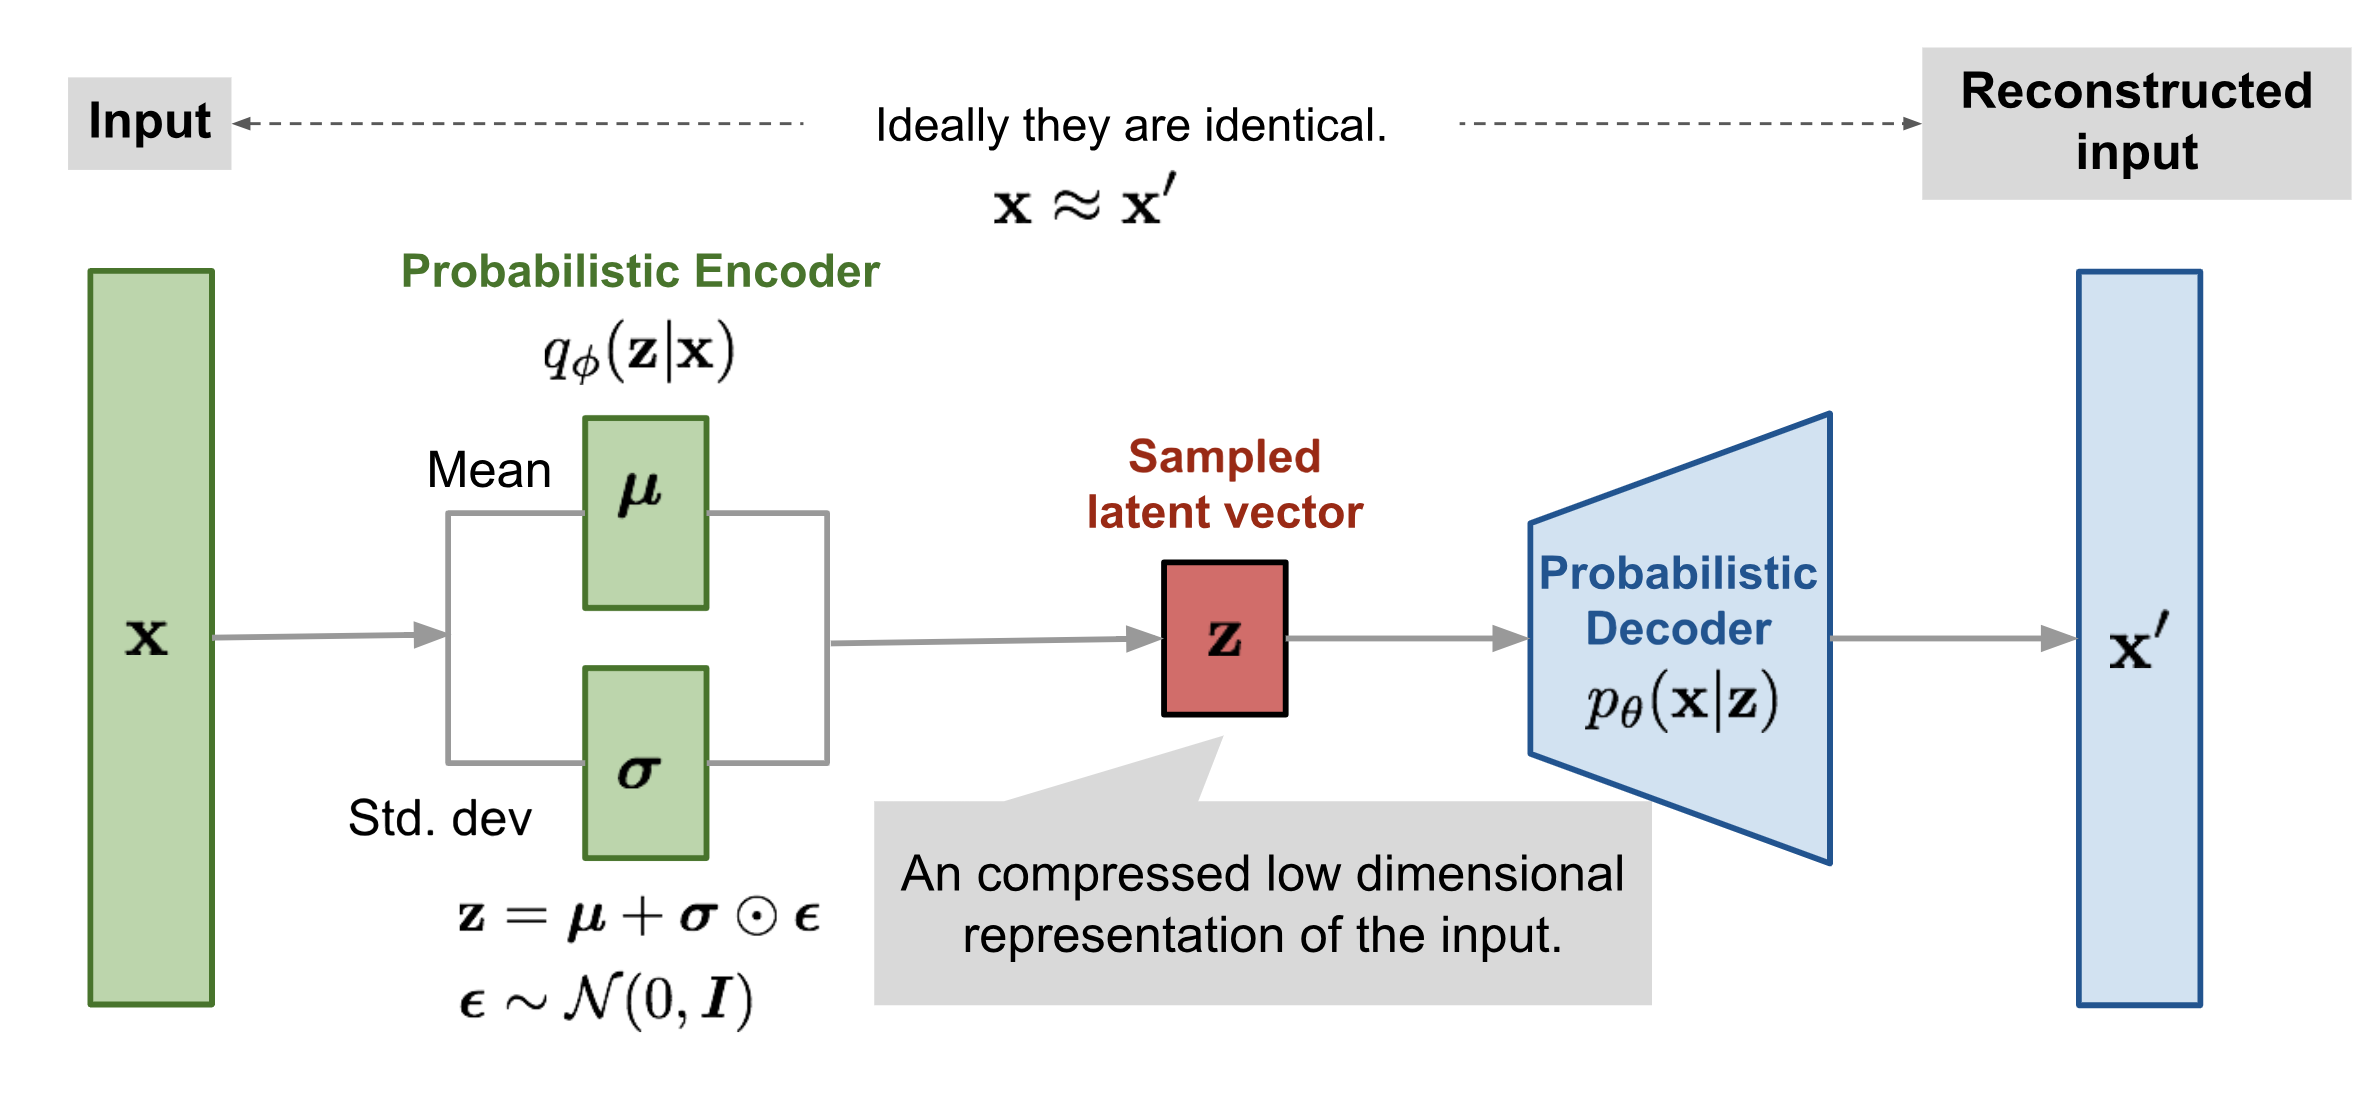

1. Which **loss** function are we optimizing? How do we optimize it?

2. What parameters do we optimize?

3. How does it relate to the EM algorithm?

```python
for x in dataloader:
    vae_opt.zero_grad()
    loss = vae_loss(x) # what is the loss function here???
    loss.backward()
    vae_opt.step()
```

We have samples $x_1, \dots x_N$ from unknown distribution $p(x)$.

1. Our optimal goal is to maximize **ELBO**:

    $$L(\phi, \theta) = \sum\limits_{n = 1}^{N} \left(\mathbb{E}_{z \sim q(z_n| x_n, \phi)} \ln p(x_n|z_n, \theta) - KL(q(z_n| x_n, \phi)||p(z_n))\right)$$
    
   but we do it in a tricky way:
   
   * $p(z_n) = \mathcal{N}(0, I_{\text{z_dim}})$
   
   * $q(z_n| x_n, \phi) = \mathcal{N}\big{(}\mu_z(x_n|\phi), \text{diag}\left( \sigma^{(1)}_z(x_n| \phi), \dots \sigma^{(\text{z_dim})}_z(x_n | \phi)\right)\big{)}$
   
   * $\Rightarrow$ $KL(q(z_n| x_n, \phi)||p(z_n))$ has closed-form expression (as a function of $\mu_z(x_n|\phi), \boldsymbol{\sigma_z}(x_n | \phi)$)
   
   * $p(x_n | z_n, \theta) = $
       
       * $\mathcal{N}\big{(}\mu_x(z_n|\theta), \text{diag}\left( \sigma^{(1)}_x(z_n| \theta), \dots \sigma^{(\text{x_dim})}_x(z_n | \theta)\right)\big{)}$, <span style="color:red"> or </span>
       
       * $\mathcal{N}\big{(}\mu_x(z_n|\theta), I_{\text{x_dim}}\big{)}$
   
   * One-sample estimate of $\mathbb{E}_{z \sim q(z_n| x_n, \phi)} \ln p(x_n|z_n, \theta)$ : 
   
   $$\mathbb{E}_{z_n \sim q(z_n| x_n, \phi)} \ln p(x_n|z_n, \theta) = \mathbb{E}_{\epsilon \sim \mathcal{N}(0, I_{\text{z_dim}})} \ln p\big{(}x_n \big{|}\mu_z(x_n | \phi) + \boldsymbol{\sigma}_z(x_n | \phi) \odot \epsilon, \theta \big{)} \approx\\ \approx \ln p\big{(} x_n \big{|} \mu_z(x_n | \phi) + \boldsymbol{\sigma}_z(x_n | \phi) \odot \epsilon_n, \theta\big{)}\, , \, \epsilon_n \sim \mathcal{N}(0, I_{\text{z_dim}})$$
   
    **Subquestion 5.1**: How to compute the log-likelihood $\ln p(x_n | z_n, \theta)$?
    
   <span style="color:red"> Final **ELBO** objective (`vae_loss`) </span>: We substitute **ELBO** objective with stochastic estimate of **ELBO** objective scaled by $\frac{\text{batch_size}}{N}$:
   
   $$
   \text{vae_loss} = \frac{1}{\text{batch_size}} \sum\limits_{i = 1}^{\text{batch_size}} \Big{(} - \ln p\big{(} x_{b[i]} \big{|} \mu_z(x_{b[i]} | \phi) + \boldsymbol{\sigma}_z(x_{b[i]} | \phi) \odot \epsilon_i, \theta\big{)} + KL(q(z_{b[i]}| x_{b[i]}, \phi)||p(z_{b[i]}))\Big{)} \approx - \frac{1}{N} L(\phi, \theta)
   $$
 
 
2. We optimize ELBO with respect to both $\phi$ (decoder parameters) and $\theta$ (encoder parameters) 

3. The optimization procedure is actually **Variational EM** algorithm in a joint manner:

$$\phi_{k + 1} = \phi_{k} + \eta \nabla_{\phi} L(q(\cdot| \boldsymbol{X}, \phi), \theta_k)|_{\phi=\phi_{k}} \\
\theta_{k + 1} = \theta_{k} + \eta \nabla_{\theta} L(q(\cdot| \boldsymbol{X}, \color{red}{\phi_{k}}), \theta)|_{\theta=\theta_{k}}$$

### 2D VAE implementation

In [21]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.distributions as TD

import pickle
import os
import sys

if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 0
    torch.cuda.set_device(GPU_DEVICE)
    USE_CUDA = True
else:
    DEVICE='cpu'
    USE_CUDA = False

from typing import Optional, Tuple
from tqdm.notebook import tqdm

Loading `dgm_utils` for colab users

In [ ]:
REPO_NAME = "2023-DGM-MIPT-course"
!if [ -d {REPO_NAME} ]; then rm -Rf {REPO_NAME}; fi
!git clone https://github.com/r-isachenko/{REPO_NAME}.git
!cd {REPO_NAME}
!pip install ./{REPO_NAME}/homeworks/
!rm -Rf {REPO_NAME}

Loading `dgm_utils` from local

In [3]:
import os, sys
DGM_UTILS_PATH = '../../homeworks'
sys.path.append(DGM_UTILS_PATH)

In [9]:
from dgm_utils import train_model, plot_training_curves
from dgm_utils import visualize_2d_data, visualize_2d_samples
from dgm_utils import show_samples, visualize_images, load_dataset

In what follows we will implement simple VAE model for 2d gaussian distribution $\mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma})$.

We will consider two cases: 
* 2d univariate distribution (diagonal covariance matrix $\boldsymbol{\Sigma}$);
* 2d multivariate distribution (strictly non-diagonal covariance matrix $\boldsymbol{\Sigma}$).

The goal is to analyze the difference between these two cases and understand why the trained VAE models will behave differently.

Below you will find data generation function. Look carefully, do not change.

In [10]:
def generate_2d_data(
    count: int, mode: str = "univariate"
) -> Tuple[np.ndarray, np.ndarray]:
    assert mode in ["univariate", "multivariate"]
    np.random.seed(42)
    mean = [[2.0, 3.0]]
    sigma = [[3.0, 1.0]]
    if mode == "univariate":
        rotate = [[1.0, 0.0], [0.0, 1.0]]
    else:
        rotate = [[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]]
    data = mean + (np.random.randn(count, 2) * sigma).dot(rotate)
    data = data.astype("float32")
    split = int(0.7 * count)
    train_data, test_data = data[:split], data[split:]
    return train_data, test_data

Let generate the data and visualize it. We will generate data for two cases.

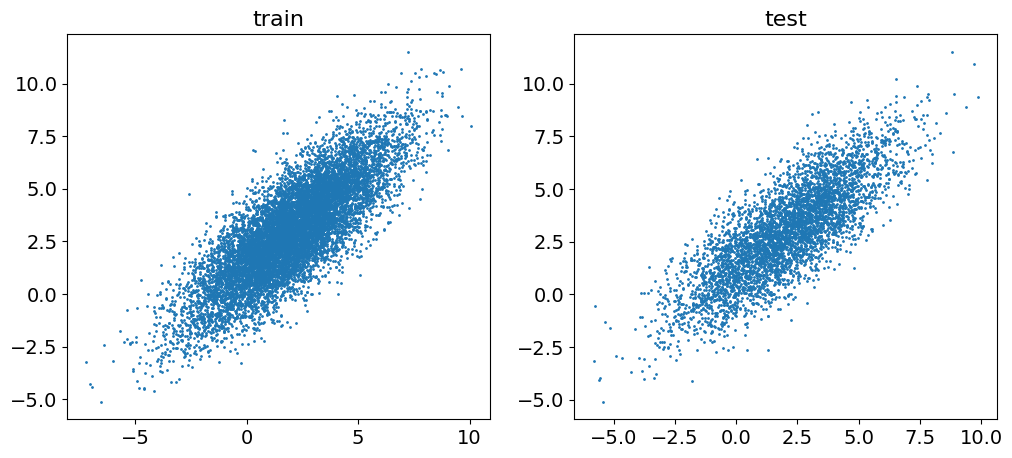

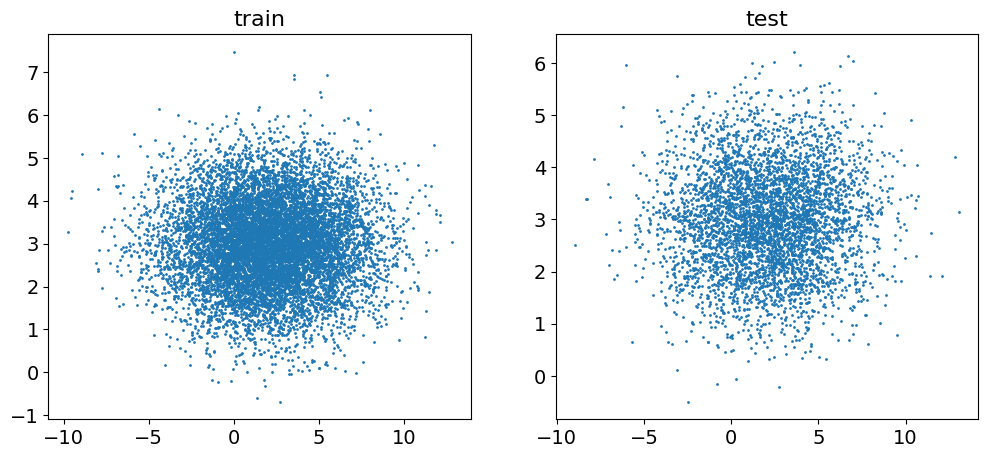

In [11]:
COUNT = 15000

train_data, test_data = generate_2d_data(COUNT, mode="multivariate")
visualize_2d_data(train_data, test_data)

train_data, test_data = generate_2d_data(COUNT, mode="univariate")
visualize_2d_data(train_data, test_data)

The difference of these two cases is the form of covariance matrix $\boldsymbol{\Sigma}$.

In multivariate case the matrix is non-diagonal, in univariate case it is strictly diagonal. As you will see, our VAE model will have absolutely different results for these datasets.

Now it is time to define our model. Our model will have the following structure:

* The latent dimensionality is equal to 2, the same as the data dimensionality ($\mathbf{z} \in \mathbb{R}^2$, $\mathbf{x} \in \mathbb{R}^2$).
* Prior distribution is standard Normal ($p(\mathbf{z}) = \mathcal{N}(0, I)$).
* Variational posterior distribution (or encoder) is $q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) = \mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\phi}}(\mathbf{x}), \boldsymbol{\Sigma}_{\boldsymbol{\phi}}(\mathbf{x}))$. Here $\boldsymbol{\phi}$ denotes all parameters of the encoder neural network. 
* Generative distribution (or decoder) is $p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{theta}}(\mathbf{z}), \boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}))$. Here $\boldsymbol{\theta}$ denotes all parameters of the decoder neural network. Please note, that here we will use continuous distribution for our variables $\mathbf{x}$.
* We will consider only diagonal covariance matrices $\boldsymbol{\Sigma}_{\boldsymbol{\phi}}(\mathbf{x})$, $\boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z})$.

Model objective is ELBO:
$$
    \mathcal{L}(\boldsymbol{\phi}, \boldsymbol{\theta}) = \mathbb{E}_{q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi})} \log p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta}) - KL (q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) || p(\mathbf{z})).
$$

To make the expectation is independent of parameters $\boldsymbol{\phi}$, we will use reparametrization trick.

To calculate the loss, we should derive
- $\log p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta})$, note that generative distribution is $\mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z}), \boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}))$.
- KL between $\mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\phi}}(\mathbf{x}), \boldsymbol{\Sigma}_{\boldsymbol{\phi}}(\mathbf{x}))$ and $\mathcal{N}(0, I)$.

Let start with the helper functions.

In [14]:
def get_normal_KL(
    mean_1: torch.Tensor,
    log_std_1: torch.Tensor,
    mean_2: Optional[torch.Tensor] = None,
    log_std_2: Optional[torch.Tensor] = None,
) -> torch.Tensor:
    """
    :Parameters:
    mean_1: means of normal distributions (1)
    log_std_1 : standard deviations of normal distributions (1)
    mean_2: means of normal distributions (2)
    log_std_2 : standard deviations of normal distributions (2)
    :Outputs:
    kl divergence of the normal distributions (1) and normal distributions (2)
    ---
    This function should return the value of KL(p1 || p2),
    where p1 = Normal(mean_1, exp(log_std_1) ** 2), p2 = Normal(mean_2, exp(log_std_2) ** 2).
    If mean_2 and log_std_2 are None values, we will use standard normal distribution.
    Note that we consider the case of diagonal covariance matrix.
    """
    if mean_2 is None:
        mean_2 = torch.zeros_like(mean_1)
    if log_std_2 is None:
        log_std_2 = torch.zeros_like(log_std_1)
    assert mean_1.shape == log_std_1.shape == mean_2.shape == log_std_2.shape
    # ====
    # your code
    return (
        (log_std_2 - log_std_1)
        + (torch.exp(log_std_1 * 2) + (mean_1 - mean_2) ** 2)
        / 2
        / torch.exp(log_std_2 * 2)
        - 0.5
    )
    # ====


def test_KL():
    assert np.isclose(
        get_normal_KL(
            torch.tensor(2), torch.tensor(3), torch.tensor(0), torch.tensor(0)
        ).numpy(),
        200.2144,
        rtol=1e-3,
    )
    assert np.isclose(
        get_normal_KL(
            torch.tensor(2), torch.tensor(3), torch.tensor(4), torch.tensor(5)
        ).numpy(),
        1.50925,
        rtol=1e-3,
    )
    assert np.allclose(
        get_normal_KL(
            torch.tensor((10, 10)), torch.tensor((2, 4)), torch.tensor((3, 5))
        ).numpy(),
        [49.2990, 1498.479],
        rtol=1e-3,
    )


test_KL()

In [13]:
def get_normal_nll(
    x: torch.Tensor, mean: torch.Tensor, log_std: torch.Tensor
) -> torch.Tensor:
    """
    This function should return the negative log likelihood log p(x),
    where p(x) = Normal(x | mean, exp(log_std) ** 2).
    Note that we consider the case of diagonal covariance matrix.
    """
    # ====
    # your code
    return (
        0.5 * np.log(2 * np.pi)
        + log_std
        + (x - mean) ** 2 * torch.exp(-2 * log_std) * 0.5
    )
    # ====


def test_NLL():
    assert np.isclose(
        get_normal_nll(torch.tensor(2), torch.tensor(2), torch.tensor(3)).numpy(),
        3.9189,
        rtol=1e-3,
    )
    assert np.isclose(
        get_normal_nll(torch.tensor(5), torch.tensor(-3), torch.tensor(6)).numpy(),
        6.9191,
        rtol=1e-3,
    )
    assert np.allclose(
        get_normal_nll(
            torch.tensor((10, 10)), torch.tensor((2, 4)), torch.tensor((3, 5))
        ).numpy(),
        np.array([3.9982, 5.9197]),
        rtol=1e-3,
    )


test_NLL()

We will use simple fully connected dense networks for encoder and decoder.

In [17]:
class FullyConnectedMLP(nn.Module):
    def __init__(self, input_shape: int, hiddens: list, output_shape: int) -> None:
        assert isinstance(hiddens, list)
        super().__init__()
        self.input_shape = (input_shape,)
        self.output_shape = (output_shape,)
        self.hiddens = hiddens

        model = []

        # ====
        # your code 
        # stack Dense layers with ReLU activation
        # note: you do not have to add relu after the last dense layer
        prev_h = input_shape
        for h in hiddens:
            model.append(nn.Linear(prev_h, h))
            model.append(nn.ReLU())
            prev_h = h
        model.append(nn.Linear(hiddens[-1], output_shape))
        # ====
        self.net = nn.Sequential(*model)

    def forward(self, x: torch.Tensor) ->  torch.Tensor:
        # ====
        # your code
        # apply network that was defined in __init__ and return the output
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        return self.net(x).view(batch_size, *self.output_shape)
        # ====

Now it is time to implement the VAE model.

In [18]:
class VAE2d(nn.Module):
    def __init__(
        self, n_in: int, n_latent: int, enc_hidden_sizes: list, dec_hidden_sizes: list
    ) -> None:
        assert isinstance(enc_hidden_sizes, list)
        assert isinstance(dec_hidden_sizes, list)
        super().__init__()
        self.n_latent = n_latent

        # ====
        # your code
        # define encoder and decoder networks
        # the encoder takes n_in elements, has enc_hidden_sizes neurons in hidden layers
        # and outputs 2 * n_latent (n_latent for means, and n_latent for std)
        # the decoder takes n_latent elements, has dec_hidden_sizes neurons in hidden layers
        # and outputs 2 * n_in (n_in for means, and n_in for std)
        self.encoder = FullyConnectedMLP(n_in, enc_hidden_sizes, 2 * n_latent)
        self.decoder = FullyConnectedMLP(n_latent, dec_hidden_sizes, 2 * n_in)
        # ====

    def prior(self, n: int) -> torch.Tensor:
        # ====
        # your code
        # return n samples from prior distribution (we use standard normal for prior)
        return torch.randn(n, self.n_latent).cuda()
        # ====

    def forward(self, x: torch.Tensor) -> tuple:
        # ====
        # your code
        # now you have to return from the model
        # - mu_z - means for variational distribution
        # - mu_x - means for generative distribution
        # - log_std_z - logarithm of std for variational distribution
        # - log_std_x - logarithm of std for generative distribution
        # we use logarithm, since the std is always positive
        # to get std we will exponentiate it to get rid of this constraint

        # 1) mu_z, log_std_z are outputs from the encoder
        # 2) apply reparametrization trick to get z (input of decoder)
        # (do not forget to use self.prior())
        # 3) mu_x, log_std_x are outputs from the decoder
        #    Note: [mu, log_std = decoder(input).chunk(2, dim=1)]

        mu_z, log_std_z = self.encoder(x).chunk(2, dim=1)
        z = self.prior(mu_z.shape[0]) * log_std_z.exp() + mu_z
        mu_x, log_std_x = self.decoder(z).chunk(2, dim=1)
        # ====
        return mu_z, log_std_z, mu_x, log_std_x

    def loss(self, x: torch.Tensor) -> dict:
        mu_z, log_std_z, mu_x, log_std_x = self(x)
        # ====
        # your code
        # 1) apply model to get mu_z, log_std_z, mu_x, log_std_x
        # 2) compute reconstruction loss using get_normal_nll (it is the first term in ELBO)
        # 3) compute KL loss using get_normal_KL (it is the second term in ELBO)
        recon_loss = get_normal_nll(x, mu_x, log_std_x)
        recon_loss = recon_loss.sum(1).mean()

        kl_loss = get_normal_KL(mu_z, log_std_z)
        kl_loss = kl_loss.sum(1).mean()
        # ====

        return {
            "elbo_loss": recon_loss + kl_loss,
            "recon_loss": recon_loss,
            "kl_loss": kl_loss,
        }

    def sample(self, n: int, sample_from_decoder: bool = True) -> np.ndarray:
        with torch.no_grad():
            # ====
            # your code
            # to sample from VAE model you have to sample from prior
            # and then apply decoder to prior samples.
            # parameter noise indicates whether to sample from decoder
            # or just use means of generative distribution as samples
            # 1) generate prior samples
            # 2) apply decoder
            # 3) sample from the decoder distribution if sample_from_decoder=True
            z = self.prior(n)
            mu, log_std = self.decoder(z).chunk(2, dim=1)
            if sample_from_decoder:
                z = torch.randn_like(mu) * log_std.exp() + mu
            else:
                z = mu
            # ====
        return z.cpu().numpy()

We will use the following function for training our models. Look carefully, do not change.

In [19]:
def solve_task(
    train_data: np.ndarray,
    test_data,
    model: np.ndarray,
    batch_size: int,
    epochs: int,
    lr: float,
    use_cuda: bool = False,
    use_tqdm: bool = False,
) -> None:
    train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

    train_losses, test_losses = train_model(
        model,
        train_loader,
        test_loader,
        epochs=EPOCHS,
        lr=LR,
        use_cuda=use_cuda,
        use_tqdm=use_tqdm,
        loss_key="elbo_loss",
    )
    samples_noise = model.sample(3000, sample_from_decoder=True)
    samples_nonoise = model.sample(3000, sample_from_decoder=False)

    for key, value in test_losses.items():
        print("{}: {:.4f}".format(key, value[-1]))

    plot_training_curves(train_losses, test_losses)
    visualize_2d_samples(samples_noise, title="Samples with Decoder Noise")
    visualize_2d_samples(samples_nonoise, title="Samples without Decoder Noise")

In [22]:
# ====
# your code
# choose these parameters (2 hidden layers could be enough for encoder and decoder)
ENC_HIDDEN_SIZES = [128, 128]
DEC_HIDDEN_SIZES = [128, 128]
BATCH_SIZE = 128  # any adequate value
EPOCHS = 10  # < 10
LR = 0.001  # < 1e-2
# ====

COUNT = 10000

Firstly, we will train the VAE model for multivariate gaussian distribution.

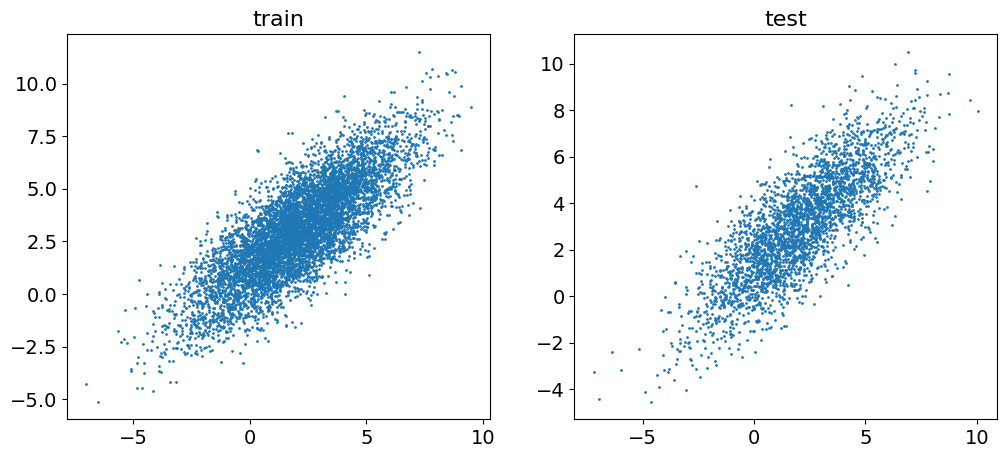

elbo_loss: 3.9994
recon_loss: 2.9415
kl_loss: 1.0579


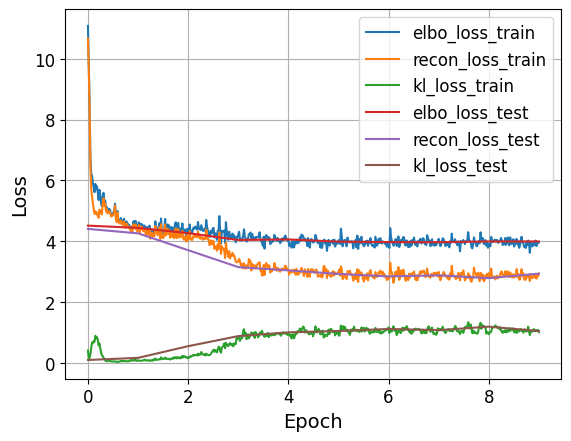

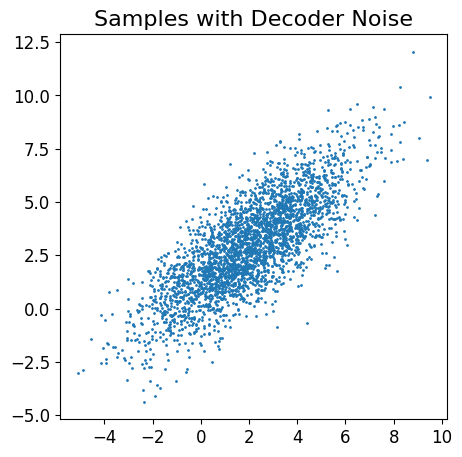

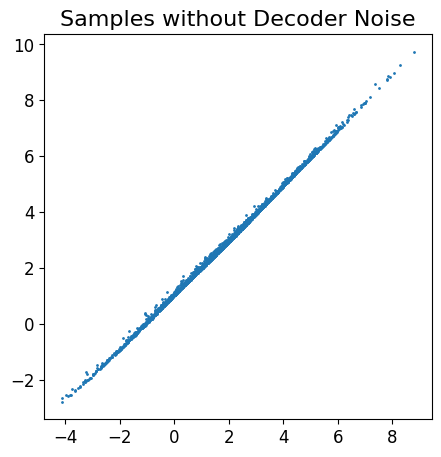

In [23]:
train_data, test_data = generate_2d_data(COUNT, mode="multivariate")
visualize_2d_data(train_data, test_data)

model = VAE2d(2, 2, ENC_HIDDEN_SIZES, DEC_HIDDEN_SIZES)
solve_task(train_data, test_data, model, BATCH_SIZE, EPOCHS, LR, use_cuda=USE_CUDA)

To analyze our models we will use the following function. Look carefully, do not change.

This function calculates the mean $\boldsymbol{\mu}_{\boldsymbol{\phi}}(\mathbf{x})$, and covariances $\boldsymbol{\Sigma}_{\boldsymbol{\phi}}(\mathbf{x})$ of the variational posterior distribution $q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi})$.

In [24]:
def get_latent_stats(
    model: object, test_data: np.ndarray, use_cuda: bool = True, batch_size: int = 3000
) -> tuple:
    batch = next(iter(data.DataLoader(test_data, batch_size=batch_size, shuffle=True)))
    if use_cuda:
        batch = batch.cuda()

    with torch.no_grad():
        mu_z, log_std_z = model(batch)[:2]

    mu_z = mu_z.cpu().numpy()
    std_z = log_std_z.exp().cpu().numpy()

    return mu_z, std_z

In [25]:
# just look at these numbers and read the comments after this task
mu_z, std_z = get_latent_stats(model, test_data)

print("mu_z = ", mu_z.mean(axis=0), "+-", mu_z.std(axis=0))
print("std_z = ", std_z.mean(axis=0), "+-", std_z.std(axis=0))

mu_z =  [ 0.00237347 -0.00257511] +- [0.9538615  0.02409481]
std_z =  [0.35402563 1.0059688 ] +- [0.01022613 0.03399412]


Secondly, we will train the VAE model for univariate gaussian distribution.

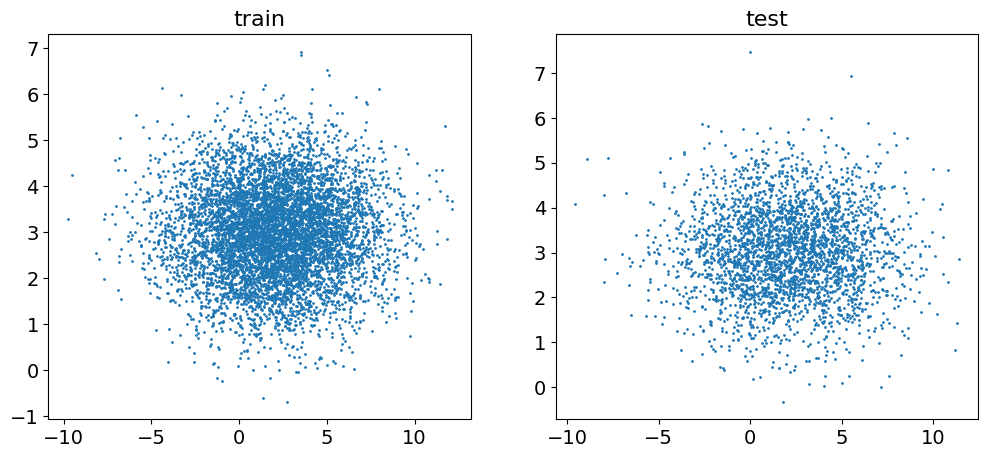

elbo_loss: 3.9486
recon_loss: 3.9284
kl_loss: 0.0203


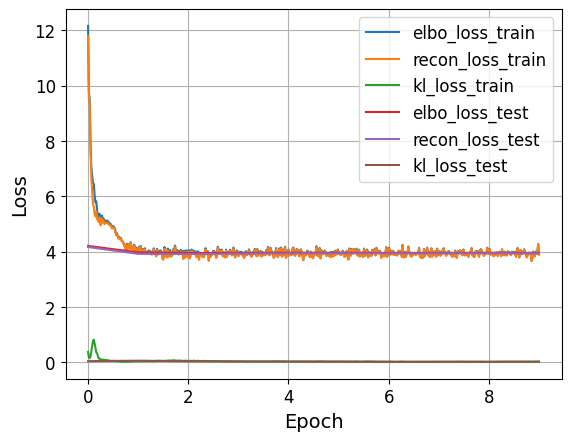

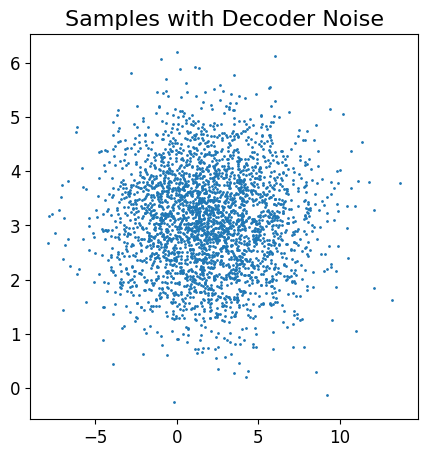

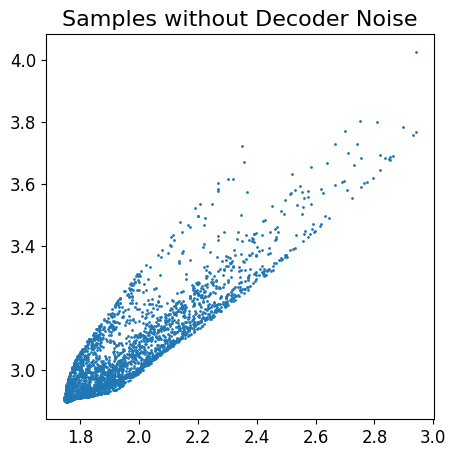

In [26]:
train_data, test_data = generate_2d_data(COUNT, mode="univariate")
visualize_2d_data(train_data, test_data)

model = VAE2d(2, 2, ENC_HIDDEN_SIZES, DEC_HIDDEN_SIZES).cuda()
solve_task(train_data, test_data, model, BATCH_SIZE, EPOCHS, LR, use_cuda=USE_CUDA)

In [27]:
# just look at these numbers and read comments after this task
mu_z, std_z = get_latent_stats(model, test_data)

print("mu_z = ", mu_z.mean(axis=0), "+-", mu_z.std(axis=0))
print("std_z = ", std_z.mean(axis=0), "+-", std_z.std(axis=0))

mu_z =  [-0.0204501   0.02958949] +- [0.04912616 0.09596855]
std_z =  [1.0031935  0.95943797] +- [0.08481741 0.06926398]


After training the VAE model on these 2 datasets, have a look at "Samples without Decoder Noise" figures. These figures show the means $\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z})$ of the generative distribution $p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta})$. In the case of multivariate gaussian, the means are perfectly aligned with the data distribution. 
Otherwise, you have to see the strange figure in the univariate gaussian case . This happens due to so called **posterior collapse** (we will discuss it at the one of our lectures).

To be brief, the reason is the following. Our posterior distribution $p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z}), \boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}))$ is a univariate (covariance matrix is diagonal). Thus, the model does not need latent variable since the data distribution is also univariate. In this case VAE ignores latent variable, cause the model fits the distribution without any information from latent space.

If the decoder ignores latent variable, the second term in ELBO (KL) could be low (variational posterior distribution, which is given by encoder model, is close to prior distribution for each datapoint). In the training curves you have to see that KL loss behaves differently in these two cases.

The mean and std of variational posterior distribution also proves this concept. For the second case you have to see that mean is almost zero and std is almost one.

It is a real problem for generative models and we will discuss later how to overcome it.

## Posterior collapse and decoder weakening

\<in slides\>

### $\beta$-annealing of VAE

[link1](https://openreview.net/pdf?id=Sy2fzU9gl) to the article

$$\max\limits_{\phi, \theta} L(q(\cdot| \boldsymbol{X}, \phi), \theta) \longrightarrow \begin{array}{l}\max\limits_{\phi, \theta} E_{z_1, \dots z_N \sim q(\boldsymbol{z} | \boldsymbol{x})} \ln p(x_1, \dots, x_N | \boldsymbol{z}, \theta) \\ \text{s.t. } KL\big{(}q(z_1, \dots z_N | \boldsymbol{x}) \big{|}\big{|} p(z_1, \dots z_N)\big{)} < \varepsilon \end{array}$$

Objective:

$$L(\phi, \theta, \beta) = \sum\limits_{n = 1}^{N} \left(\mathbb{E}_{z \sim q(z_n| x_n, \phi)} \ln p(x_n|z_n, \theta) - \beta KL(q(z_n| x_n, \phi)||p(z_n))\right)$$

* Setting $\beta > 1$ at the end of optimization procedure makes the latent codes more disentangled ("распутанными") [link1](https://openreview.net/pdf?id=Sy2fzU9gl)

* Setting $0 \leq \beta \ll 1$ at the beginning of optimization procedure  helps to eliminate KL vanishing at the beginning of optimization [link2](https://arxiv.org/pdf/1903.10145.pdf)

**Question.** Which VAE problem could be relaxed via $\beta$-annealing?

**Answer.:** Making $0 \leq \beta \ll 1$ helps to relax **posterior collapse** (independence of $p(x | z, \theta)$ from $z$)